### Import Packages ###

In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.fft import fftshift, ifftn
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

### Generate Data ###

In [ ]:
N, l = 64, 3.2e-3
fx1D = torch.linspace(-np.pi/l, np.pi/l, N)
fy1D = torch.linspace(-np.pi/l, np.pi/l, N)
[fx2D, fy2D] = torch.meshgrid(fx1D, fy1D, indexing='xy')
k2D = torch.sqrt(fx2D**2 + fy2D**2) * N
theta2D = torch.arctan2(fy2D, fx2D) + np.pi/2 # Add `np.pi/2` to match the polar definition of the theta.
theta1D = torch.linspace(0, 2*np.pi, N)

### PACT psf Calculation Formulas ###

In [ ]:
def wavefront_fourier(C0, C1, phi1, C2, phi2):
    return lambda theta: C0 + C1 * torch.cos(theta - phi1) + C2 * torch.cos(2 * (theta - phi2))

def wavefront_real(R, r, phi, v0, v1):
    return lambda theta: (1-v0/v1) * (torch.sqrt(R**2 - (r*torch.sin(theta-phi))**2) + r * torch.cos(theta-phi))


def PSF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+np.pi)))) / 2
    psf = fftshift(ifftn(tf, dim=[-2,-1]), dim=[-2,-1]).abs()
    psf /= psf.sum(axis=(-2,-1)) # Normalization.
    return psf


### Data Generation for phi and r###
The graph plotted is to indicate how r is generated in the range of 0 to R (0.01m)

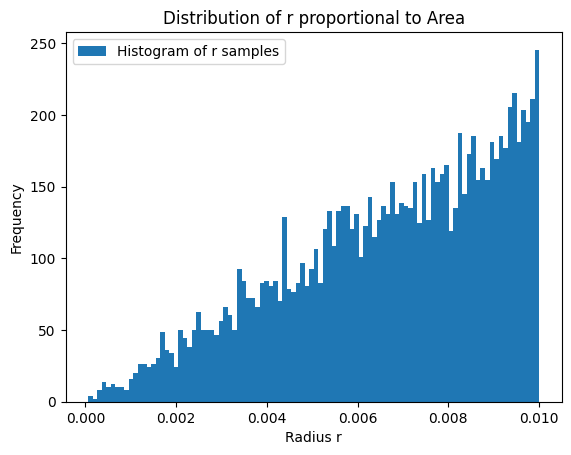

In [ ]:
num_samples = 5000
v0 = 1500
v1 =1600
R = 0.01 # m
phi_list = np.random.uniform(0, 2 * np.pi, num_samples)

phi_max = 2 * np.pi
probability = np.random.uniform(0, 1, num_samples)
r_list = R * np.sqrt(probability)
plt.hist(r_list, bins=100, density=True, label='Histogram of r samples')

plt.xlabel('Radius r')
plt.ylabel('Frequency')
plt.title('Distribution of r proportional to Area')
plt.legend()
plt.show()

### Data Generation for delay ###

In [ ]:
# update delays
delay_step=1e-4
delays = torch.linspace(-(8/2-1), 8/2, num_samples, requires_grad=False) * delay_step

### Date Generation for C1, C2, C0 ###
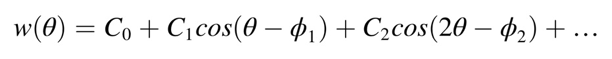

The generation of loss_ave and loss_std is prepared for data normalization.

In [ ]:
C1_values = [(1-v0/v1) * r for r in r_list]
C1_ave = np.mean(C1_values)
C1_std = np.std(C1_values)

C2_values = [(1-v0/v1) * r**2 / (4*R) for r in r_list]
C2_ave = np.mean(C2_values)
C2_std = np.std(C2_values)

C0_values =[ (1-v0/v1) * R * (1 - (r**2)/(4*R**2)) for r in r_list]
C0_ave = np.mean(C0_values)
C0_std = np.std(C0_values)

phi_ave = np.mean(phi_list)
phi_std = np.std(phi_list)

delay_ave = np.mean(delays.numpy())
delay_std = np.std(delays.numpy())


loss_ave = [phi_ave, C0_ave, C1_ave, C2_ave, delay_ave]
loss_std = [phi_std,C0_std,C1_std,C2_std, delay_std]


In [ ]:
w_fourier_list = []
w_real_list = []
for i in range(num_samples):
  # v0 = v0_list[i]
  # v1 = v1_list[i]
  phi = phi_list[i]
  C0 = (1-v0/v1) * R * (1 - (r_list[i]**2)/(4*R**2))
  C1 = (1-v0/v1) * r_list[i]
  C2 = (1-v0/v1) * r_list[i]**2 / (4*R)
  w_fourier = wavefront_fourier(C0, C1, phi, C2, phi)
  w_real = wavefront_real(R, r_list[i], phi, v0, v1)
  w_fourier_list.append(w_fourier)
  w_real_list.append(w_real)


### Data Generation for the input ###

In [ ]:
images = []
for h in range(num_samples):
  offset = (1-v0/v1) * R * 7/8
  delay = delays[h]


  for i, (w, label) in enumerate(zip([w_fourier_list[h]], ['Fourier', 'Real'])):
    images.append(PSF(theta2D, k2D, w, delay))
print(images[0].shape)

torch.Size([64, 64])


### Visualisation for generated psf for 5 random samples ###

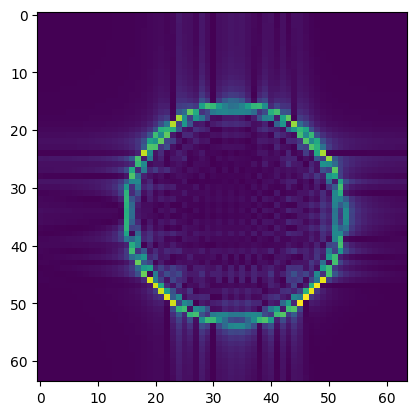

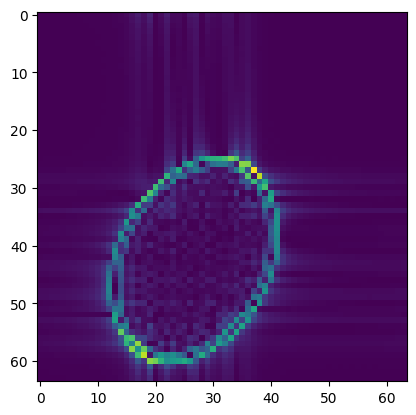

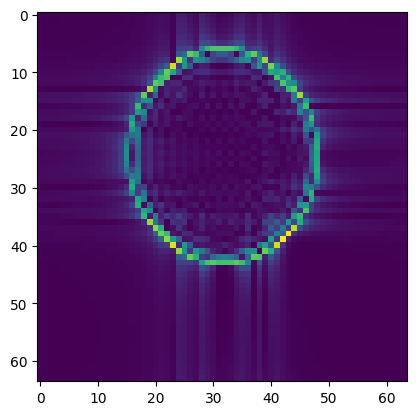

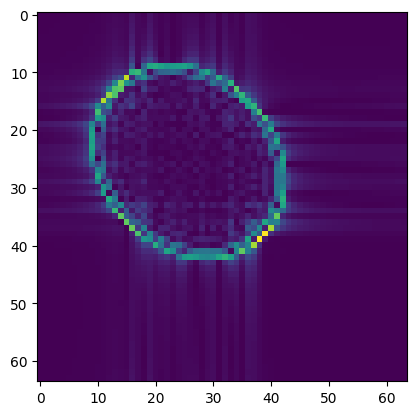

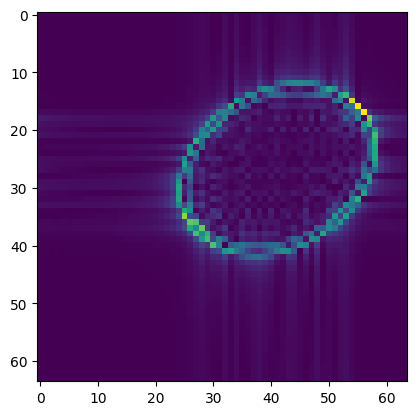

In [ ]:
for i in range(5):
  plt.figure()
  plt.imshow(images[i*100])

In [ ]:
print(images[0].shape)

torch.Size([64, 64])


### Building the model ###

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
          nn.Dropout(),
          nn.Linear(256 * 6 * 6, 4096),
          nn.ReLU(inplace=True),
          nn.Dropout(),
          nn.Linear(4096, 4096),
          nn.ReLU(inplace=True),
          nn.Linear(4096, 5),
      )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### Parameters Defined ###
loss function: mean square

optimizer: Adam

learning rate: 0.0001

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Here the ground truth is normalised before put into the model.

In [ ]:

images_tensor = torch.stack(images)
labels = np.vstack((phi_list,C0_values, C1_values, C2_values, delays)).T
labels = (labels-loss_ave) / loss_std
labels_tensor = torch.tensor(labels, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(images_tensor.numpy(), labels_tensor.numpy(), test_size=0.2)


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

### Train the model for 30 epochs ###

In [ ]:
# Train the model
# (ground truth -average)/std
num_epochs = 30
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    max_loss = 1
    for inputs, targets in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()

      optimizer.step()
      running_loss += loss.item()* inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

Epoch [1/30] Loss: 1.2343
Epoch [2/30] Loss: 0.8181
Epoch [3/30] Loss: 0.8123
Epoch [4/30] Loss: 0.8018
Epoch [5/30] Loss: 0.7960
Epoch [6/30] Loss: 0.7397
Epoch [7/30] Loss: 0.3600
Epoch [8/30] Loss: 0.1890
Epoch [9/30] Loss: 0.1036
Epoch [10/30] Loss: 0.0885
Epoch [11/30] Loss: 0.0739
Epoch [12/30] Loss: 0.0686
Epoch [13/30] Loss: 0.0650
Epoch [14/30] Loss: 0.0555
Epoch [15/30] Loss: 0.0575
Epoch [16/30] Loss: 0.0511
Epoch [17/30] Loss: 0.0494
Epoch [18/30] Loss: 0.0444
Epoch [19/30] Loss: 0.0449
Epoch [20/30] Loss: 0.0476
Epoch [21/30] Loss: 0.0427
Epoch [22/30] Loss: 0.0407
Epoch [23/30] Loss: 0.0402
Epoch [24/30] Loss: 0.0384
Epoch [25/30] Loss: 0.0375
Epoch [26/30] Loss: 0.0381
Epoch [27/30] Loss: 0.0347
Epoch [28/30] Loss: 0.0348
Epoch [29/30] Loss: 0.0387
Epoch [30/30] Loss: 0.0326


### Test the model ###

In [ ]:
# Validate the model
model.eval()
target = None
input = None
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        input = inputs[0]
        output_pam = outputs.numpy()[0] * loss_std + loss_ave
        w = wavefront_fourier(output_pam[1], output_pam[2], output_pam[0], output_pam[3], output_pam[0])
        output = PSF(theta2D, k2D, w, output_pam[4]).detach().numpy()
        target_pam = targets.numpy()[0] * loss_std + loss_ave
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
    print(f"Test Loss: {test_loss/len(test_loader.dataset):.4f}")


Test Loss: 0.0409


### One random visualisation of the predicted psf ###
The upper image is the ground truth

The bottom image is constructed using the parameters predicted.
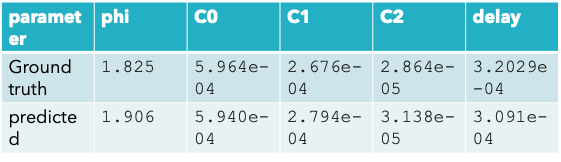

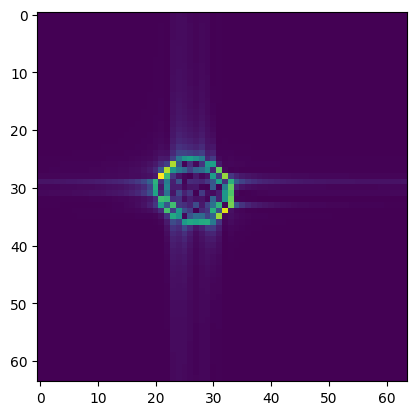

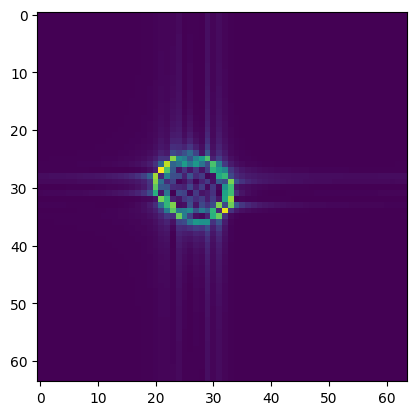

In [ ]:
plt.figure()
plt.imshow(input.squeeze())
plt.figure()
plt.imshow(output)

### The loss before being non-normalised ###

[0.31664813 0.07089043 0.41804433 0.16892445 0.17953321]
[0.09779117 0.04602488 0.30127132 0.13533928 0.13269745]


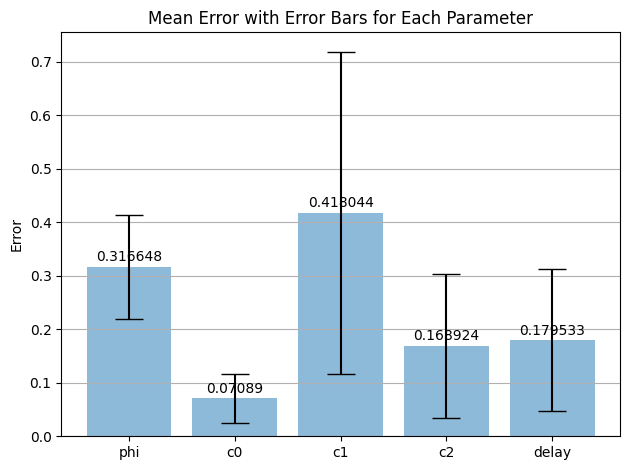

In [ ]:
# Calculate the errors and standard deviations
errors = abs((outputs - targets).numpy())
mean_errors = np.mean(errors, axis=0)
std_errors = np.std(errors, axis=0)
print(mean_errors)
print(std_errors)

# Plot the average error and error bars for each parameter
parameters = ['phi', 'c0', 'c1', 'c2', 'delay']
fig, ax = plt.subplots()
bars = ax.bar(parameters, mean_errors, yerr=std_errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Error')
ax.set_title('Mean Error with Error Bars for Each Parameter')
ax.yaxis.grid(True)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 6), ha='center', va='bottom')
plt.tight_layout()
plt.show()

### The loss of phi after being non-normalised ###

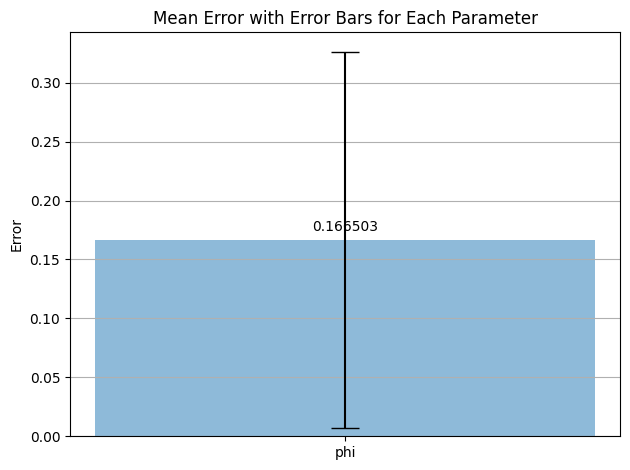

In [ ]:
# Calculate the errors and standard deviations
errors = abs((outputs - targets).numpy())
errors = errors * loss_std
mean_errors_phi = np.mean(errors, axis=0)[0]
std_errors_phi = np.std(errors, axis=0)[0]


# Plot the average error and error bars for each parameter
parameters = ['phi']
fig, ax = plt.subplots()
bars = ax.bar(parameters, mean_errors_phi, yerr=std_errors_phi, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Error')
ax.set_title('Mean Error with Error Bars for Each Parameter')
ax.yaxis.grid(True)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 6), ha='center', va='bottom')
plt.tight_layout()
plt.show()

### The loss of rest of the parameters after being non-normalised ###

[7.84438511e-06 2.13483774e-05 7.68878731e-06 1.80730012e-05]
[6.19122567e-06 1.48897774e-05 6.16251860e-06 1.28531161e-05]


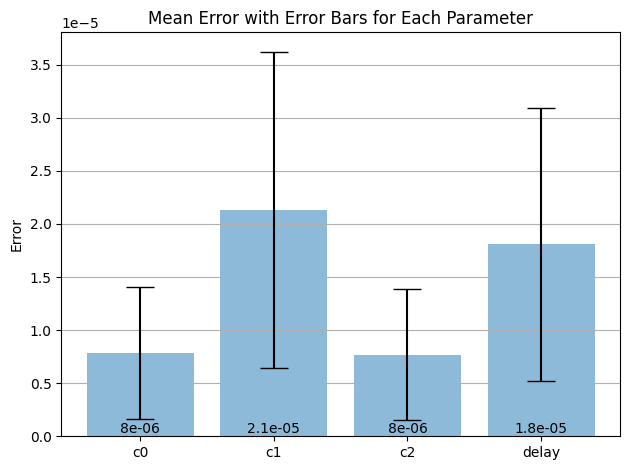

In [ ]:
# Calculate the errors and standard deviations
errors = abs((outputs - targets).numpy())
errors = errors * loss_std
mean_errors = np.mean(errors, axis=0)[1:]
std_errors = np.std(errors, axis=0)[1:]
print(mean_errors)
print(std_errors)

# Plot the average error and error bars for each parameter
parameters = ['c0', 'c1', 'c2', 'delay']
fig, ax = plt.subplots()
bars = ax.bar(parameters, mean_errors, yerr=std_errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Error')
ax.set_title('Mean Error with Error Bars for Each Parameter')
ax.yaxis.grid(True)
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval * 0.001, round(yval, 6), ha='center', va='bottom')
plt.tight_layout()
plt.show()

### save the model ###

In [ ]:
torch.save(model, 'alex_net_model.pth')